Let's see if LSI, a common dimensionality reduction method in NLP, can give us any interesting results.

In [29]:
from gensim.models import LsiModel
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
from go_learning_helpers import *
import matplotlib.pyplot as plt
import scipy.sparse as sp
%matplotlib notebook

In [30]:
file_name = 'kinase_go_annotations.csv'
path_to_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(path_to_dir+file_name)

In [31]:
'''# binarize
lb, go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)'''

'# binarize\nlb, go_annotations = convert_go_annotations_to_one_hot(go_annotations,\n                                                   return_binarizer= True)'

In [32]:
from collections import defaultdict
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1

texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

In [33]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.save('./go.dict')
print(dictionary)

Dictionary(1850 unique tokens: ['angiogenesis', 'axon', 'axon guidance', 'axon guidance receptor activity', 'camera-type eye morphogenesis']...)


In [34]:
corpus = [dictionary.doc2bow(doc) for doc in texts]
corpora.MmCorpus.serialize('./go.mm', corpus)

In [35]:
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus)

In [36]:
corpus_tfidf = tfidf[corpus]

In [37]:
'''id_dict = {}
for x in range(len(go_annotations)):
    one_hot_array = np.zeros((len(go_annotations),1))
    one_hot_array.itemset(x, 1)
    id_dict[x] = lb.inverse_transform(one_hot_array)'''

'id_dict = {}\nfor x in range(len(go_annotations)):\n    one_hot_array = np.zeros((len(go_annotations),1))\n    one_hot_array.itemset(x, 1)\n    id_dict[x] = lb.inverse_transform(one_hot_array)'

In [123]:
# binarize
filtered_go_annotations
lb, binarized_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

go_matrix = np.vstack([x for x in binarized_go_annotations])
go_sparse = sp.csc_matrix(go_matrix.T)

In [128]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components =3)

tsvd.fit(go_matrix.T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [229]:
a, b = map(np.asarray, zip(*corpus_tfidf[10]))
row = np.repeat(0, len(a))
print(row)
print(a)
print(b)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  9  32  37  60  62 129 156 157 199 200 201 202 203 204 205 206 207 208]
[0.03614918 0.13151053 0.14750414 0.13151053 0.06020903 0.09207151
 0.22619538 0.22619538 0.349712   0.32010649 0.18651641 0.22356011
 0.24079504 0.37764061 0.17419693 0.45369657 0.20098847 0.20298867]


In [232]:
sp.csc_matrix((b, (row, a)), shape=(1,1850))

<1x1850 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Column format>

In [234]:
hold = []
for i in range(473):
    if(i is not 163):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,1850))]

In [239]:
tsvd.fit(sp.vstack(hold).toarray().T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [240]:
tsvd.explained_variance_ratio_

array([0.01823324, 0.01704196, 0.01215485])

In [39]:
mod = LsiModel(corpus=corpus_tfidf, num_topics=2, id2word=dictionary)

In [40]:
mod.print_topics(2)

[(0,
  '0.149*"peptidyl-tyrosine phosphorylation" + 0.144*"intracellular signal transduction" + 0.138*"protein autophosphorylation" + 0.135*"protein tyrosine kinase activity" + 0.132*"plasma membrane" + 0.132*"nucleus" + 0.132*"cell differentiation" + 0.131*"negative regulation of apoptotic process" + 0.130*"DNA-templated" + 0.129*"protein kinase activity"'),
 (1,
  '-0.224*"negative regulation of signal transduction" + -0.216*"transmembrane receptor protein tyrosine kinase activity" + -0.216*"transmembrane signaling receptor activity" + -0.202*"integral component of plasma membrane" + -0.198*"receptor complex" + -0.197*"positive regulation of ERK1 and ERK2 cascade" + -0.196*"cell differentiation" + 0.175*"stress-activated protein kinase signaling cascade" + 0.168*"signal transduction by protein phosphorylation" + 0.163*"activation of protein kinase activity"')]

In [41]:
corpus_lsi = mod[corpus_tfidf]

In [42]:
corpus_lsi.obj.show_topics(2)

[(0,
  '0.149*"peptidyl-tyrosine phosphorylation" + 0.144*"intracellular signal transduction" + 0.138*"protein autophosphorylation" + 0.135*"protein tyrosine kinase activity" + 0.132*"plasma membrane" + 0.132*"nucleus" + 0.132*"cell differentiation" + 0.131*"negative regulation of apoptotic process" + 0.130*"DNA-templated" + 0.129*"protein kinase activity"'),
 (1,
  '-0.224*"negative regulation of signal transduction" + -0.216*"transmembrane receptor protein tyrosine kinase activity" + -0.216*"transmembrane signaling receptor activity" + -0.202*"integral component of plasma membrane" + -0.198*"receptor complex" + -0.197*"positive regulation of ERK1 and ERK2 cascade" + -0.196*"cell differentiation" + 0.175*"stress-activated protein kinase signaling cascade" + 0.168*"signal transduction by protein phosphorylation" + 0.163*"activation of protein kinase activity"')]

<IPython.core.display.Javascript object>


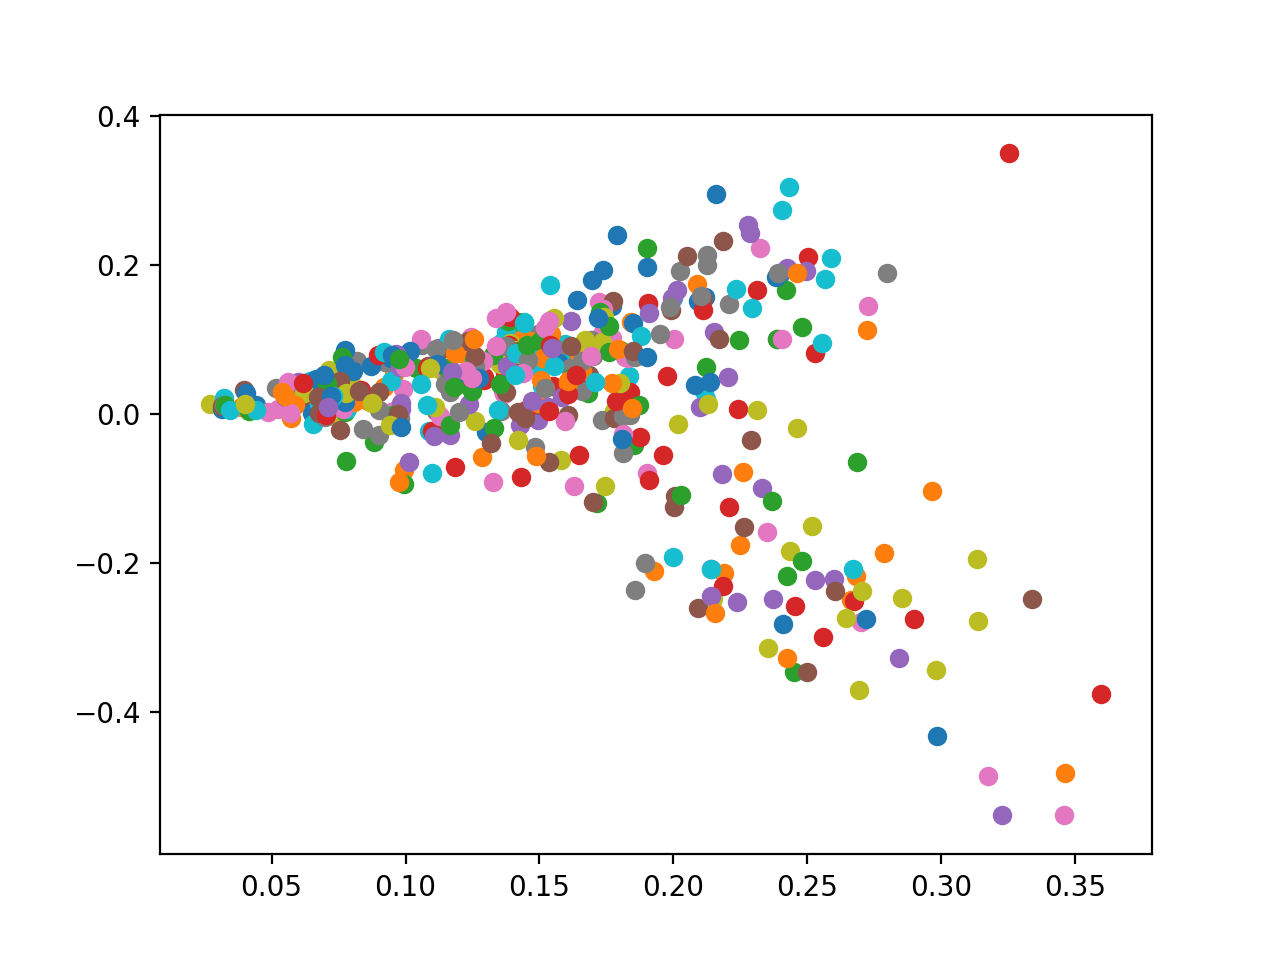

163


In [43]:
fig, ax = plt.subplots()
for i in range(473):
    try:
        ax.scatter(x=corpus_lsi[i][0][1], y = corpus_lsi[i][1][1])
    except:
        print(i)

In [44]:
mod_3 = LsiModel(corpus=corpus_tfidf, num_topics=3, id2word=dictionary)

In [45]:
corpus_lsi_3 = mod_3[corpus_tfidf]

In [46]:
corpus_lsi_3.obj.show_topics(3)

[(0,
  '0.149*"peptidyl-tyrosine phosphorylation" + 0.144*"intracellular signal transduction" + 0.137*"protein autophosphorylation" + 0.135*"protein tyrosine kinase activity" + 0.132*"plasma membrane" + 0.132*"nucleus" + 0.131*"cell differentiation" + 0.130*"negative regulation of apoptotic process" + 0.130*"DNA-templated" + 0.130*"protein kinase activity"'),
 (1,
  '0.224*"negative regulation of signal transduction" + 0.216*"transmembrane signaling receptor activity" + 0.216*"transmembrane receptor protein tyrosine kinase activity" + 0.202*"integral component of plasma membrane" + 0.198*"receptor complex" + 0.197*"positive regulation of ERK1 and ERK2 cascade" + 0.196*"cell differentiation" + -0.176*"stress-activated protein kinase signaling cascade" + -0.168*"signal transduction by protein phosphorylation" + -0.164*"activation of protein kinase activity"'),
 (2,
  '0.331*"stress-activated protein kinase signaling cascade" + 0.331*"signal transduction by protein phosphorylation" + 0.30

<IPython.core.display.Javascript object>


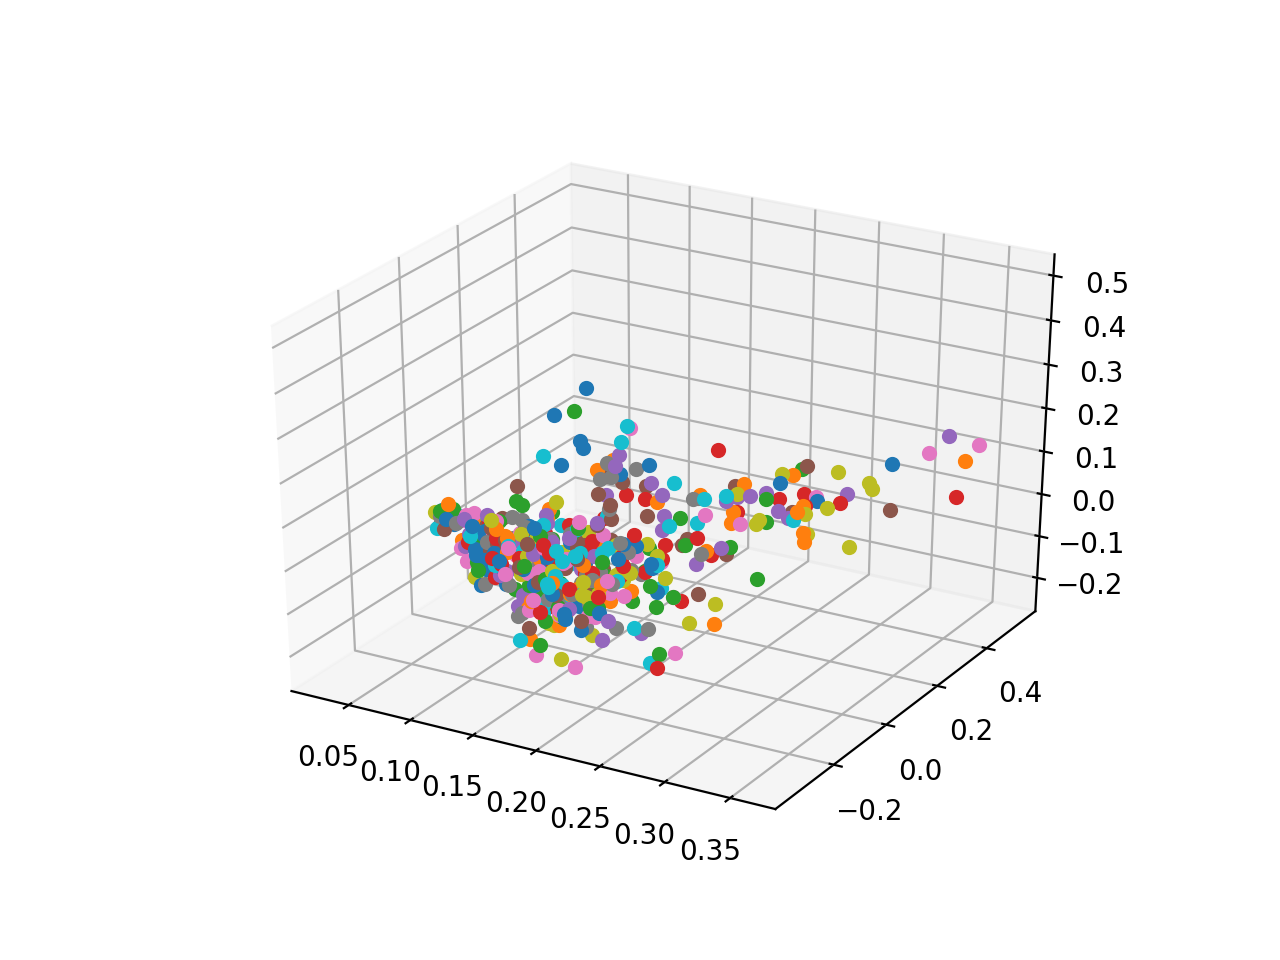

163


In [47]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(473):
    try:
        ax.scatter(corpus_lsi_3[i][0][1], corpus_lsi_3[i][1][1], corpus_lsi_3[i][2][1])
    except:
        print(i)

In [20]:
ind = go_annotations.index.tolist()

In [48]:
corpus_lsi_3[0]

[(0, 0.24065061350075523), (1, 0.2841353163664786), (2, 0.06576914016584917)]

In [49]:
consensus_file_name = 'consensusclusters_spinglass_greaterthan90percent.txt'
path_to_consensus = '../reproduced/'

consensus_dat = add_cluster_labels(path_to_consensus+consensus_file_name,
                                  go_annotations)

print(consensus_dat.head(5))

       cluster                                          GO Labels
names                                                            
PAK1         1  [positive regulation of JUN kinase activity, n...
ERBB2        2  [peptidyl-tyrosine phosphorylation, negative r...
RON          3  [positive regulation of MAP kinase activity, p...
YES          3  [postsynaptic specialization, intracellular co...
TYRO3        3  [viral entry into host cell, peptidyl-tyrosine...


In [50]:
x_coords = [corpus_lsi_3[x][0][1] for x in range(473) if len(corpus_lsi_3[x])>1]
y_coords = [corpus_lsi_3[x][1][1] for x in range(473) if len(corpus_lsi_3[x])>1]
z_coords = [corpus_lsi_3[x][2][1] for x in range(473) if len(corpus_lsi_3[x])>1]

In [51]:
colors = [consensus_dat['cluster'].loc[ind[x]] for x in range(473) if x != 163]

<IPython.core.display.Javascript object>


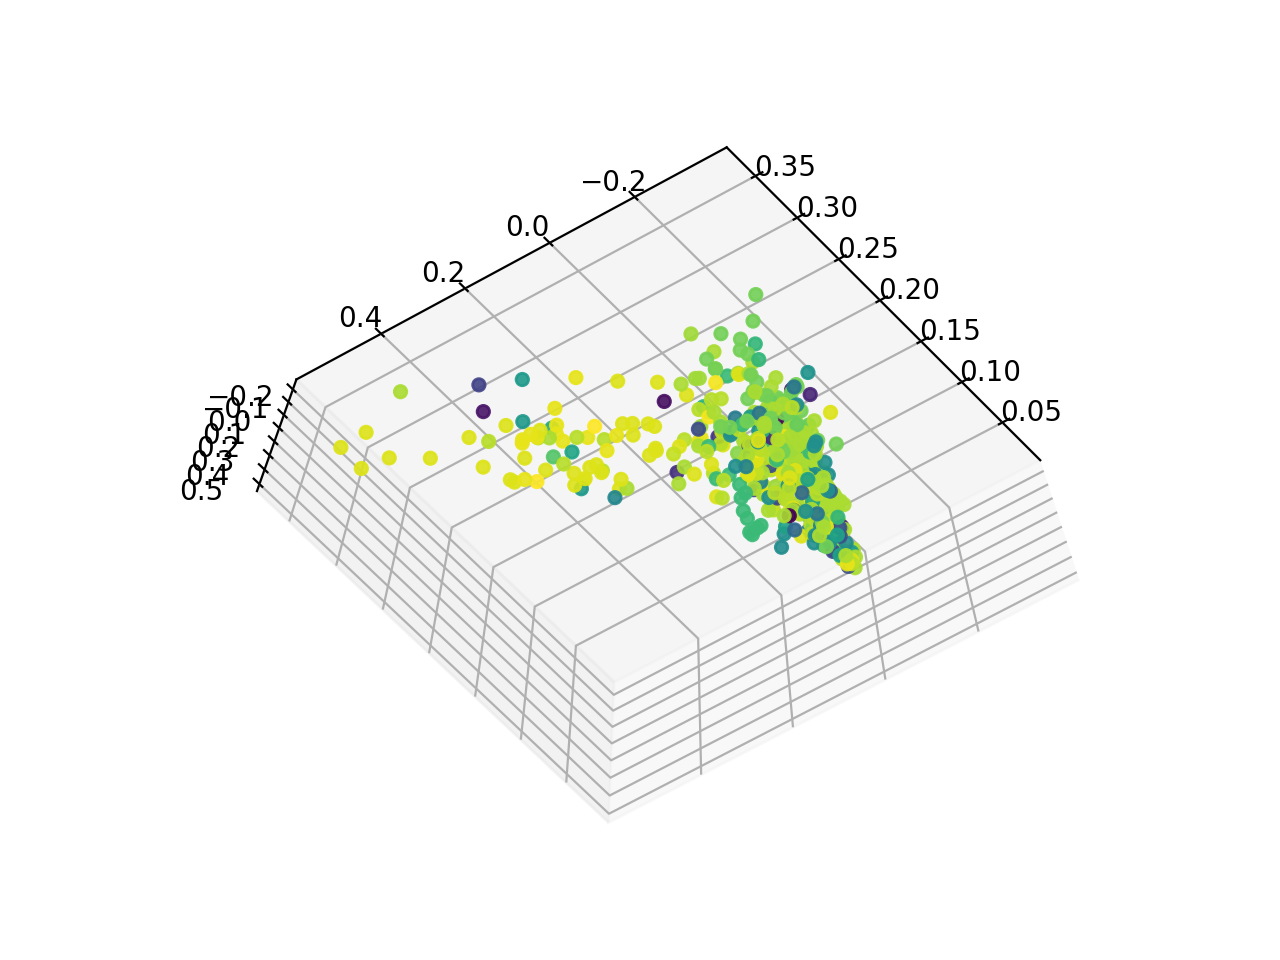

In [52]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='viridis_r')

In [53]:
fast_greedy_file_name = 'fastgreedy_clusters.txt'
path_to_fast_greedy = '../reproduced/'

fast_greedy_dat = add_cluster_labels(path_to_fast_greedy+fast_greedy_file_name,
                                  go_annotations)

print(fast_greedy_dat.head(5))

       cluster                                          GO Labels
names                                                            
PAK1         3  [positive regulation of JUN kinase activity, n...
ERBB2        3  [peptidyl-tyrosine phosphorylation, negative r...
RON          6  [positive regulation of MAP kinase activity, p...
YES          6  [postsynaptic specialization, intracellular co...
TYRO3        6  [viral entry into host cell, peptidyl-tyrosine...


In [54]:
colors = [fast_greedy_dat['cluster'].loc[ind[x]] for x in range(473) if x != 163]

<IPython.core.display.Javascript object>


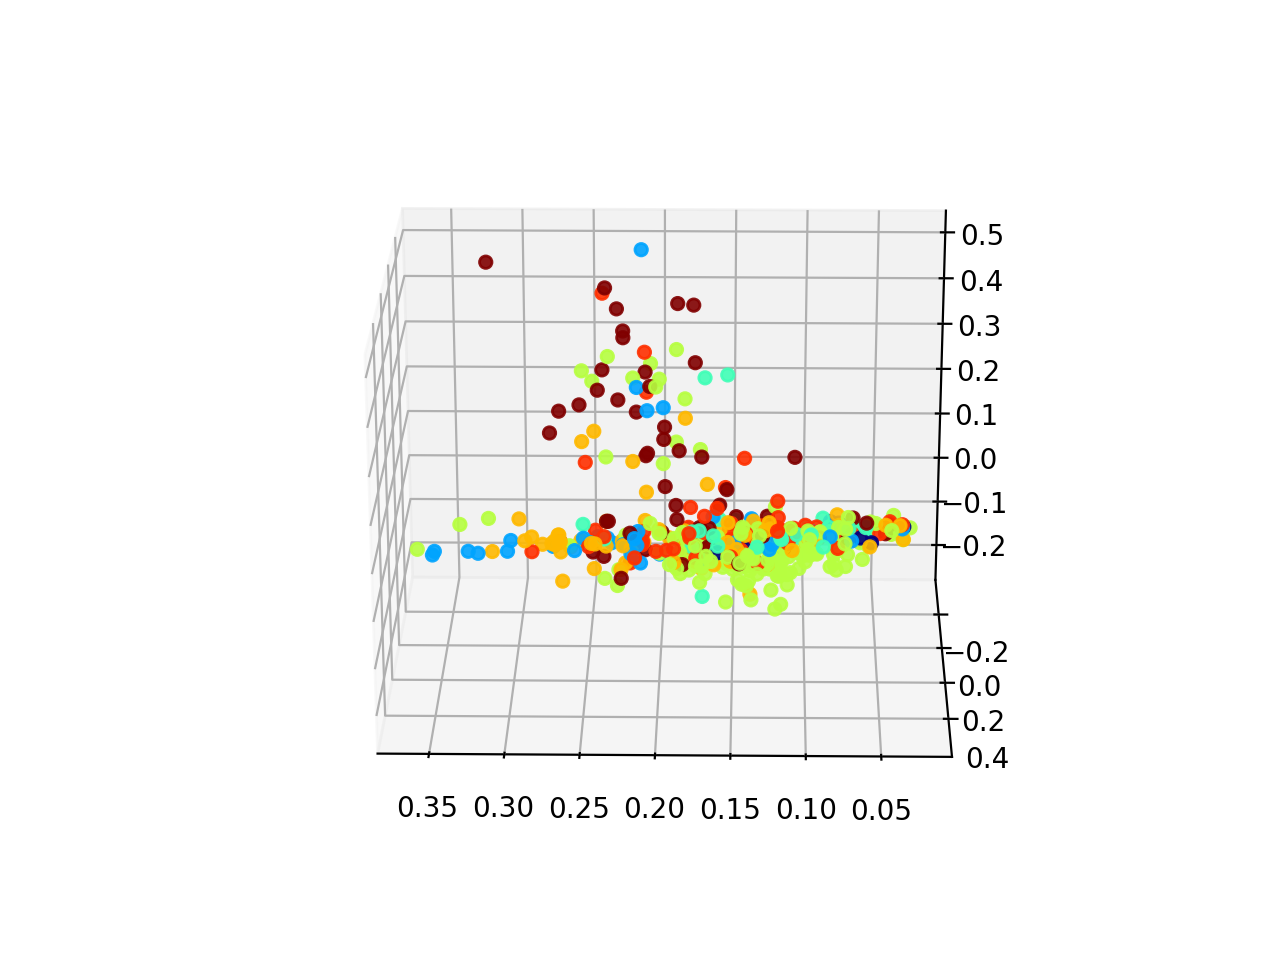

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

In [68]:
lsi_dat = pd.DataFrame(np.vstack([np.asarray(x_coords).reshape(1,472),np.asarray(y_coords).reshape(1,472), np.asarray(z_coords).reshape(1,472)]).T)

In [72]:
lsi_dat.index = [y for x, y in enumerate(ind) if x != 163]

In [74]:
lsi_dat.head()

,0,1,2
EPHB1,0.240651,0.284135,0.065769
K6PP,0.082625,-0.031811,-0.011346
MRCKG,0.119289,-0.094509,-0.047391
HCK,0.220354,0.125383,-0.048161
ROCK1,0.142736,0.014500,-0.032475


In [111]:
consensus_file_name = 'consensusclusters_spinglass_greaterthan90percent.txt'
path_to_consensus = '../reproduced/'

consensus_lsi = add_cluster_labels(path_to_consensus+consensus_file_name,
                                  lsi_dat)

print(consensus_lsi.head(5))
consensus_lsi.dropna(inplace=True, axis=0)

       cluster         0         1         2
names                                       
PAK1         1  0.219872 -0.046799  0.113355
ERBB2        2  0.279339  0.187463  0.014079
RON          3  0.256054  0.302286  0.042265
YES          3  0.200150  0.111569 -0.033498
TYRO3        3  0.218893  0.227469  0.009031


In [112]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear')
nb = GNB()
#cnb = CNB()

classifiers = [svm, nb]#, cnb]

In [114]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(consensus_lsi[[0,1,2]].values.tolist(), consensus_lsi['cluster'].values.tolist(), test_size=0.3)

for clf in classifiers:
    clf.fit(X_train, y_train);

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test)))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'matthews'))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'cohen'))

0.30985915492957744
0.36619718309859156
0.1429460242036957
0.2505077730229289
0.09507088047860568
0.2430255286382751


In [116]:
fast_greedy_file_name = 'fastgreedy_clusters.txt'
path_to_fast_greedy = '../reproduced/'

fast_greedy_lsi = add_cluster_labels(path_to_fast_greedy+fast_greedy_file_name,
                                  lsi_dat)

fast_greedy_lsi.dropna(inplace=True, axis=0)
print(fast_greedy_lsi.head(5))

       cluster         0         1         2
names                                       
PAK1         3  0.219872 -0.046799  0.113355
ERBB2        3  0.279339  0.187463  0.014079
RON          6  0.256054  0.302286  0.042265
YES          6  0.200150  0.111569 -0.033498
TYRO3        6  0.218893  0.227469  0.009031


In [120]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(fast_greedy_lsi[[0,1,2]].values.tolist(), fast_greedy_lsi['cluster'].values.tolist(), test_size=0.3)

for clf in classifiers:
    clf.fit(X_train, y_train);

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test)))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'matthews'))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'cohen'))

0.3732394366197183
0.4225352112676056
0.1308020276133153
0.24312520323334197
0.060441602854806376
0.20627130197682353


In [241]:
mod_50 = LsiModel(corpus=corpus_tfidf, num_topics=50, id2word=dictionary)

In [242]:
corpus_lsi_50 = mod_50[corpus_tfidf]

In [257]:
from sklearn.manifold import TSNE

t = TSNE(n_components=3)

In [250]:
corpus_lsi_50[1][48][1]

-0.07029010916099654

In [251]:
holder = []
for x in range(473):
    if(len(corpus_lsi_50[x])>1):
        holder.append([corpus_lsi_50[x][i][1] for i in range(50)])

In [254]:
np.vstack(map(np.array, holder)).shape

(472, 50)

In [258]:
new_dat = t.fit_transform(np.vstack(map(np.array, holder)))

In [260]:
x_coords = [coord[0] for coord in new_dat]
y_coords = [coord[1] for coord in new_dat]
z_coords = [coord[2] for coord in new_dat]

In [261]:
colors = [fast_greedy_dat['cluster'].loc[ind[x]] for x in range(473) if x != 163]

<IPython.core.display.Javascript object>


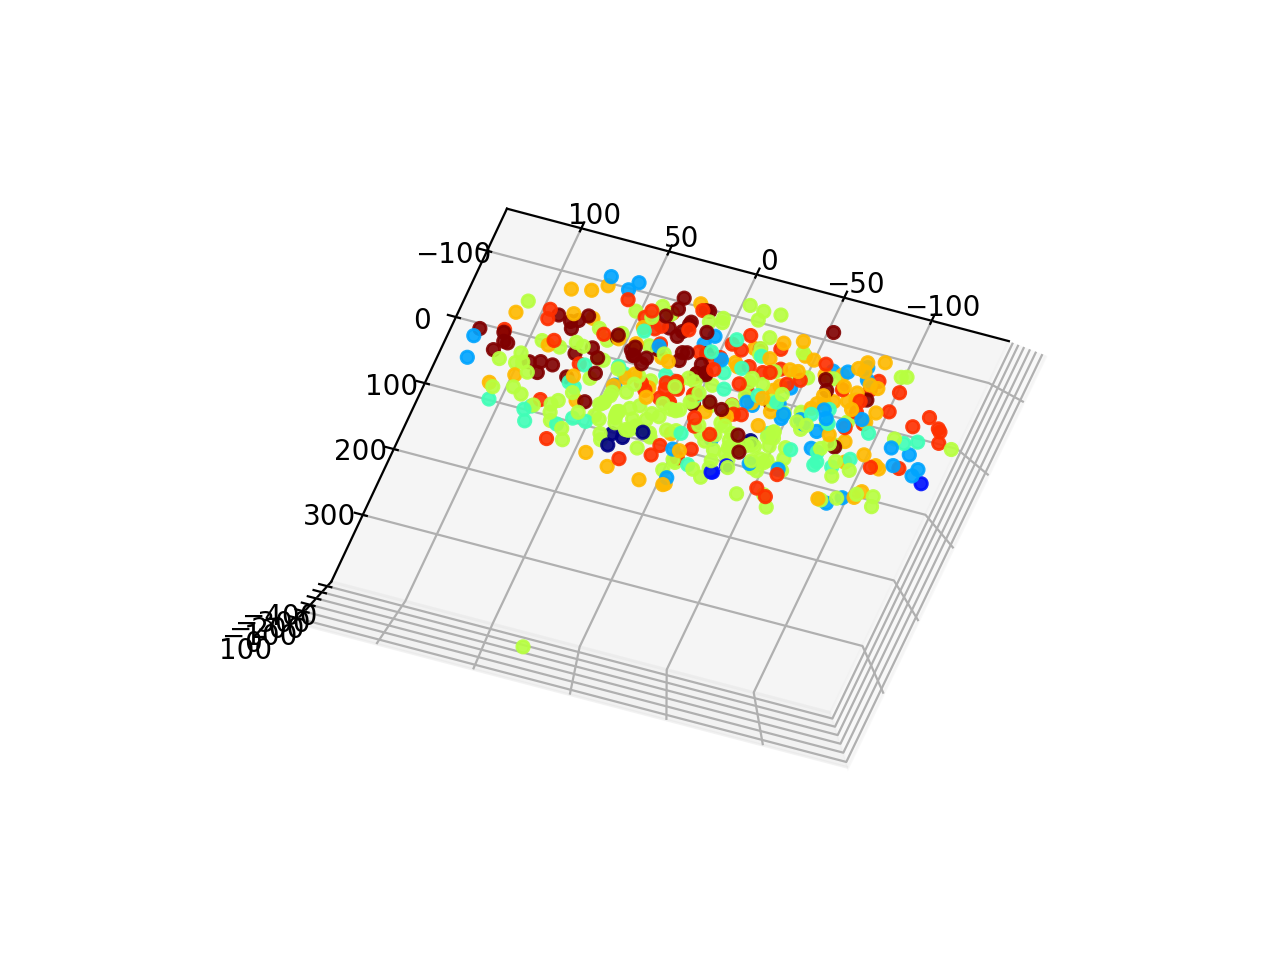

In [262]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

In [263]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=3)

In [264]:
new_dat_iso = iso.fit_transform(np.vstack(map(np.array, holder)))

In [265]:
x_coords = [coord[0] for coord in new_dat_iso]
y_coords = [coord[1] for coord in new_dat_iso]
z_coords = [coord[2] for coord in new_dat_iso]

<IPython.core.display.Javascript object>


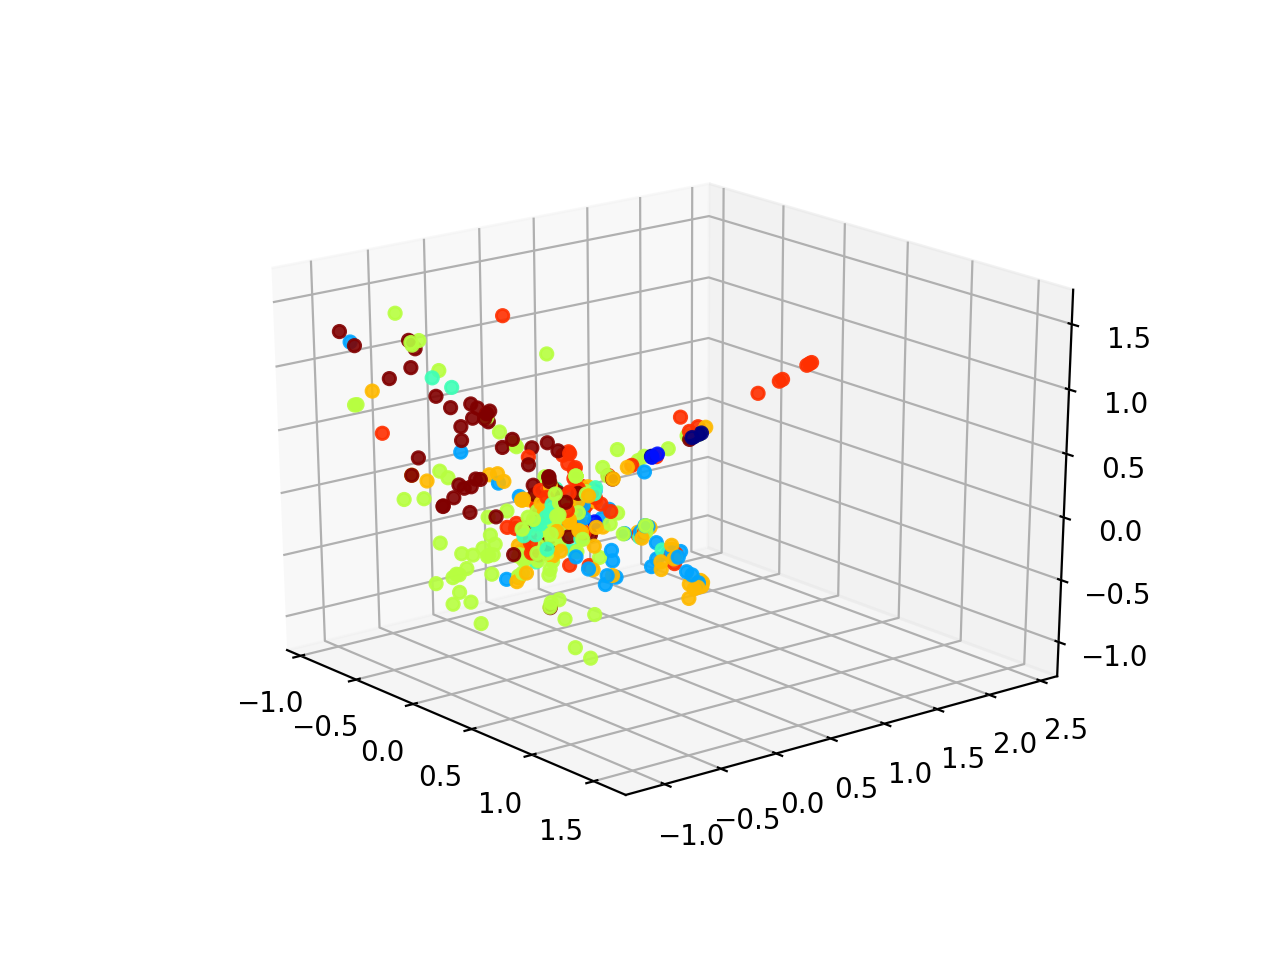

In [266]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')